In [9]:
import numpy as np
import multiprocess
from p2_1 import get_image_feature
from p1 import compute_dictionary

def build_recognition_system(num_workers = 4):
    '''
    Creates a trained recognition system by generating training features from all training images.

    [input]
    * num_workers: number of workers to process in parallel

    [saved] 
    * features: numpy.ndarray of shape (N,M)
    * labels: numpy.ndarray of shape (N)
    * dictionary: numpy.ndarray of shape (K,3F)
    * SPM_layer_num: number of spatial pyramid layers
    '''

    # Define the number of layers
    spm_layers = 4
    num_clusters = 100 # K in k means
    alpha = 150

    # Load the dictionary and training data
    train_data = np.load("./data/train_data.npz")
    compute_dictionary(alpha=alpha, n_clusters=num_clusters, out_name="dict_tuning")
    dictionary = np.load("dict_tuning.npy")

    # Parse out the training files
    train_files = train_data.get("files")
    if train_files is None:
        raise ValueError("No valid training files available :(")
    train_files = ["./data/" + str(file) for file in train_files]

    # Parse out the training labels
    labels = train_data.get("labels")
    if labels is None:
        raise ValueError("No valid labels available :(")

    # Gather arguments for multiprocessing
    args = []
    for idx, train_sample in enumerate(train_files):
        args.append((train_sample, dictionary, spm_layers, dictionary.shape[0]))

    # NxM array of the training features
    training_features = np.zeros((len(args), int(dictionary.shape[0] / 3 * (4**(spm_layers)-1))))

    # Multiprocess getting the image features
    result_dict = {}
    with multiprocess.Pool(num_workers) as p:
        # Get the result
        result = p.starmap(get_image_feature, args)

        for r in result:
            # Associate where to put it in the output list
            idx = np.argwhere(np.array(train_files) == r[0])

            # Put it in the output list
            training_features[idx[0]] = r[1]

    np.savez('trained_system_edited.npz', features=training_features,
                                    labels=labels,
                                    dictionary=dictionary,
                                    SPM_layer_num=spm_layers)


build_recognition_system()

Trained features shape:  (1000, 12750)
Predicted labels shape:  (160, 1)
My Confusion Matrix:


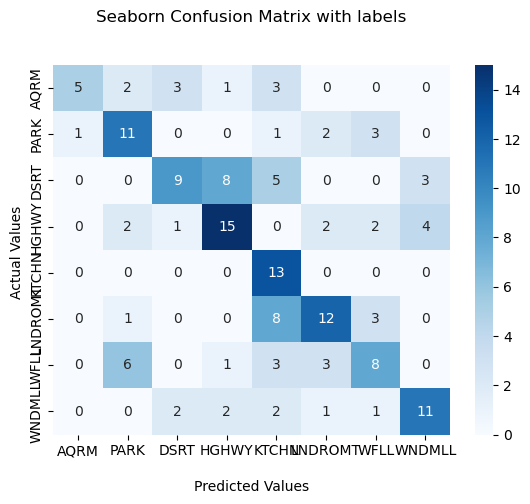

Accuracy: 0.525


In [8]:
import nbimporter
from p3 import distance_to_set
import numpy as np
import multiprocess
from p2_1 import get_image_feature
from sklearn import svm

def evaluate_recognition_system(num_workers=4):
    '''
    Evaluates the recognition system for all test images and returns the confusion matrix.

    [input]
    * num_workers: number of workers to process in parallel

    [output]
    * conf: numpy.ndarray of shape (8,8)
    * accuracy: accuracy of the evaluated system
    '''
    '''
    HINTS
    (1) You may wish to use multiprocessing to improve speed (NO Extra Points)
    (2) You may create helper function (in the same cell) to enable multiprocessing
    (3) Think Nearest Neighbor -> assign label using element closest in train set
    '''
    
    test_data = np.load("./data/test_data.npz")
    trained_system = np.load("trained_system_edited.npz")
    
    image_names = test_data['files']
    image_names = ["./data/" + str(file) for file in image_names]
    test_labels = test_data['labels']

    train_labels = trained_system['labels']
    dictionary = trained_system['dictionary']
    SPM_layer_num = trained_system['SPM_layer_num']
    SPM_layer_num = int(SPM_layer_num)
    K = dictionary.shape[0]


    trained_features = trained_system['features']
    clf = svm.SVC()
    clf.fit(trained_features, train_labels)
    print("Trained features shape: ", trained_features.shape)
    
    # Gather arguments for multiprocessing
    args = []
    for idx, train_sample in enumerate(image_names):
        args.append((train_sample, dictionary, SPM_layer_num, K))

    # NxM array of the test features
    test_features = np.zeros((len(args), int(K / 3 * (4**(SPM_layer_num)-1))))

    # Debug for one process
    # feat = get_image_feature(image_names[0], dictionary, SPM_layer_num, K)
    # idx = np.argwhere(np.array(image_names) == feat[0])[0]
    # most_similar_idx = np.argmin(distance_to_set(feat[1], trained_features))
    # pred_labels[idx] = train_labels[most_similar_idx]

    # Dictionary to hold on to our predictions
    pred_labels_dict = {}

    # Multiprocess getting the image features
    with multiprocess.Pool(num_workers) as p:
        # Get the result
        result = p.starmap(get_image_feature, args)

        for r in result:
            # Predict with SVM classifier RBF kernel
            pred_labels_dict[r[0]] = clf.predict(r[1].reshape(1, trained_features.shape[1]))
            # For the test feature, find the nearest neighbor to the trained features
            # Take the argmax because we want the highest similarity
            # most_similar_idx = np.argmax(distance_to_set(r[1], trained_features))

            # # Find out the corresponding label that is the nearest neighbor
            # pred_labels_dict[r[0]] = train_labels[most_similar_idx]

    pred_labels = np.array(list(pred_labels_dict.values()))
    print("Predicted labels shape: ", pred_labels.shape)
    
    # Look at sklearn confusion matrix to validate
    from sklearn.metrics import confusion_matrix
    sklearn_conf_matrix = confusion_matrix(test_labels, pred_labels)

    # Compute the confusion matrix
    num_labels  = len(np.unique(test_labels))
    conf_matrix = np.zeros((num_labels, num_labels))


    for i in range(len(test_labels)):
        conf_matrix[test_labels[i], pred_labels[i]] += 1

    # Calculate the accuracy
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

    # Visualize the confusion matrix
    def visualize_conf_matrix(conf_matrix):   
        import seaborn as sns
        import matplotlib.pyplot as plt
        labels = ["AQRM", "PARK", "DSRT", "HGHWY", "KTCHN", "LNDROMT", "WFLL", "WNDMLL"]
        ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')
        ax.set_title('Seaborn Confusion Matrix with labels\n\n')
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ')
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
        plt.show()

    print("My Confusion Matrix:")
    visualize_conf_matrix(conf_matrix)
    # print("Sklearn Confusion Matrix")
    # visualize_conf_matrix(sklearn_conf_matrix)

    # Save confusion matrix to a file
    np.save("./conf_matrix_paramtuning.npy", conf_matrix)
    return conf_matrix, accuracy


# NOTE: comment out the lines below before submitting to gradescope
conf_matrix, accuracy = evaluate_recognition_system()
# We expect the accuracy to be greater than 0.65
print("Accuracy:", accuracy)